# Introduction
This tutorial allows you to compute the velocity and pressure field caused by a density anomaly of ellipsoidal shape within a fluid by solving the incompressible Stokes equation for laminar flow. 
This example is called the Stokes sphere problem. It uses a finite element approach to solve the Stokes equation (force balance, or conservation of momentum) based on a package call FEniCSx.

The tutotrial will first describe two ways to obtain the computing environment for FEniCSx and the then solve the problem. We can obtain FEniCSx by installing it via package manager Anaconda or using its docker image. 
More methods could be found via the official FEniCS/dofinx GitHub repository's README.md https://github.com/FEniCS/dolfinx/blob/main/README.md.
The Stokes solve apprroach itself is modified from the official FEniCSx Sotkes demo via https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_stokes.html

# FEniCSx installation with Anaconda
For Windows users, please install Anaconda through Windows Linux Subsystem. You can install Ubuntu from Microsoft Store. 

For MacOS and Linux users, Anaconda installation package can be found here https://www.anaconda.com/products/distribution#Downloads.

For example, for Linux (or Windows Linux Subsystem) users, 
```
wget https://repo.anaconda.com/archive/Anaconda3-2022.10-Linux-x86_64.sh
bash Anaconda3-2022.10-Linux-x86_64.sh
```

For MacOS users, 
```
wget https://repo.anaconda.com/archive/Anaconda3-2022.10-MacOSX-x86_64.sh
bash Anaconda3-2022.10-MacOSX-x86_64.sh
```

With Anaconda installed, you can install FEniCSx using fenicsx-env.yml and using the following command:

```
conda env create -f fenicsx-env.yml
```
It will create an Anaconda environment named fenicsx.

For Ubuntu (Windows Linux Subsystem) users, you may need to run this command:
```
sudo apt install libgl1-mesa-glx xvfb
```
This will allow pyvista to plot.

# Activate/deactivate a conda environment
By following the above steps, FEniCSx and Jupyter Notebook is installed inside the conda environment fenicsx-env.

To activate it, 
```
conda activate fenicsx-env
```

To deactivate it
```
conda deactivate
```

# Start the Jupyter Notebook from terminal
Becuase Jupyter Notebook is installed inside the conda environment fenicsx-env, you need to activate fenicsx-env first. Then, type the following command 
```
jupyter notebook --allow-root
```

You will get a website link. Copy and paste that link to a browser should start you the Jupyter Notebook.

# FEniCSx installation with Docker
Docker Desktop can be downloaded and installed from this link https://www.docker.com/products/docker-desktop/. 

With Docker installed, please type the following command in the terminal:
```
docker run --init -ti -p 8888:8888 dolfinx/lab:stable  # Access at http://localhost:8888
```

Then, Jupyter Notebook should automatically start at port 8888. 

You can stop the container and restart it later. Then, you will see Jupyter Notebook requires a password/Token for your Jupyter server. 

Open a terminal inside the docker container, type
```
Jupyter server list
```

Copy and paste the Token (a long list of charaters following https://) to the webbrowser and set up a password. Later, you just need to type in the password to log in the Jupyter Notebook.

In [1]:
# loading packages
import numpy as np
import ufl
from dolfinx.fem import (Constant, Function, FunctionSpace, dirichletbc,
                         extract_function_spaces, form,
                         locate_dofs_topological, locate_dofs_geometrical)
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from mpi4py import MPI
from petsc4py import PETSc
from ufl import div, dx, grad, inner
from dolfinx import fem, la
from dolfinx.io import gmshio
from math import *
from dataclasses import dataclass,astuple,asdict # for C-like structure

from StokesLib import gmsh_stokes_tutorial, fem_main, block_iterative_solver
import pyvista
from dolfinx import plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
# model description: a top rectangle + a bottom rectangle + an elliptical inclusion inside the bottom rectangle.
# ---
# boundary descriptions:
# left boundary  : A
# bottom boundary: B
# right boundary : C
# top boundary   : D
# ---
# material properties:
@dataclass
class parameters: 
    # Adjustable parameters
    eta_crust  = 1.  # viscosity of the upper block.
    eta_mantle = 1.  # viscosity of the bottom block.
    eta_inc    = 10  # viscosity of the elliptical anomaly. 

    dgrav      = 10. # delta gravity anomaly for the ellipse. 

    # ----------------------------------
    # adjustable parameters for the mesh.
    dxx      = 0.1 # cell size near boundary points.
    dxx_curv = 10  # cell numbers to capture the ellipitical curvatures. More will increase the resolution near the vertexes of the ellipse.

    w   = 2.  # width of the model
    h1  = 1.  # height of the bottom rectangle
    h2  = 0.5 # heigth of the top rectangle

    xe  = w/2;  # x cooridnate of the ellipse center
    ye  = h1/2; # y coordinate of the ellipse center
    # the center of the ellipse is at the center of the bottom rectangle at (xe,ye)=(w/2,h1/2).
    ra  = 0.4 # a of the ellipse
    #ratio_a_b = 4 # ratio of a/b of the ellipse
    #rb  = ra/ratio_a_b # b of the ellipse
    rb = 0.1 
    
    rot = 0.5*pi # rotation of the ellipse counterclockwise around its center in radians.

    # ----------------------------------
    bcs_type  = 1   # please choose the boundary conditions and the options could be expanded. 
    # 1: free slip for all surfaces A-D;
    # 2: free slip for A-C, D free.
    # 3: no slip for B, fixed velocity for D, no y motion + tao_xy=0 for A and C. 
    # --- for visualization
    if bcs_type == 1:
        velocity_vector_scale_factor = 2.
    elif bcs_type == 2:
        velocity_vector_scale_factor = 0.01
    elif bcs_type == 3:
        velocity_vector_scale_factor = 0.01

In [3]:
def describeModel(par):
    print('Model description.')
    print('A 2-D block that has two horizontal layers.')
    print('The bottom and top layers are ',par.h1, par.h2, ' in height, respectively.')
    print('An ellipitical shaped anomaly that has half major and minor axis lengths of', par.ra, par.rb,' is inserted and its center is located at', par.xe, par.ye)
    print('The ellipse can be rotated counterclockwise with par.rot in radians. The default value is ', par.rot/pi, ' pi.')
    print('The viscosities of the top, bottom, and elliptical anomaly are ', par.eta_crust, par.eta_mantle, par.eta_inc, ' respectively.')
    print('The gravity anomaly for the ellipse is ', par.dgrav)
    if par.bcs_type==1:
        bcsDescription = 'free slip for all surfaces.'
    elif par.bcs_type==2:
        bcsDescription = 'free slip for lateral sides and bottom, but the top is free.'
    elif par.bcs_type==3:
        bcsDescription = 'no slip at bottom, fixed velocity for top, and only horizontal motion and no shear traction for lateral sides.'
    print('Boundary conditions are ', bcsDescription)
    print(' ')

In [4]:
def runScenario(par):
    # sovle the system
    crust_marker, mantle_marker, inc_marker, \
    left_marker, right_marker, top_marker, bottom_marker = gmsh_stokes_tutorial(par)
    a, a_p, L, bcs, V, Q, msh = fem_main(crust_marker, mantle_marker, inc_marker, 
                                         left_marker, right_marker, top_marker, bottom_marker,
                                         par)
    norm_u_1, norm_p_1, u_, p_ = block_iterative_solver(a, a_p, L, bcs, V, Q, msh)

    # visualize results using pyvista
    FigWindowSize = [600, 1400]
    FontSize = 8
    subplotter = pyvista.Plotter(shape=(2,1))
    
    # pyvista.start_xvfb()
    # create a VTK compatible mesh with function space V for velocity.
    topology, cell_types, geometry = plot.vtk_mesh(V) 
    # Note that, as of 20231025, the previous plot.create_vtk_mesh is not working anymore. Now change to plot.vtk_mesh(V)
    values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
    values[:, :len(u_)] = u_.x.array.real.reshape((geometry.shape[0], len(u_)))

    # Create a point cloud of glyphs
    grid1 = pyvista.UnstructuredGrid(topology, cell_types, geometry)
    grid1["u"] = values
    glyphs = grid1.glyph(orient="u", factor=4/norm_u_1)
    
    subplotter.subplot(0, 0)
    subplotter.add_text("Velocity", font_size=FontSize, color="black", position="upper_edge")
    subplotter.add_mesh(grid1, style="wireframe", color="k")
    subplotter.add_mesh(glyphs)
    subplotter.view_xy()
    #grid1.save('a.vtk')
        
    # to visualize the function p_, we create a VTK-compatible grid.
    # https://docs.fenicsproject.org/dolfinx/main/python/demos/demo_pyvista.html
    topology2, cell_types2, geometry2 = plot.vtk_mesh(Q) # Q is the function space for pressure.
    grid2 = pyvista.UnstructuredGrid(topology2, cell_types2, geometry2)
    # for scalar plots, use .point_data
    grid2.point_data["p"] = p_.x.array
    grid2.set_active_scalars("p")
    warped = grid2.warp_by_scalar() # using the warp function.
    subplotter.subplot(1, 0)
    subplotter.add_text("Pressure", font_size=FontSize, color="black", position="upper_edge")
    subplotter.add_mesh(grid2, show_edges=False, show_scalar_bar=True)
    subplotter.view_xy()

    if pyvista.OFF_SCREEN:
        subplotter.screenshot("VelocityAndPressure.png", transparent_background=transparent,
                              window_size=[figsize, figsize])
    else:
        subplotter.show(window_size=FigWindowSize)

## Scenario 1: an elliptical viscous anomaly with buoyancy.
You can use the describeModel function to show model setup.

Model description.
A 2-D block that has two horizontal layers.
The bottom and top layers are  1.0 0.5  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.4 0.1  is inserted and its center is located at 1.0 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 10  respectively.
The gravity anomaly for the ellipse is  10.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 428 nodes
Info    : 854 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 1.5585469461773533
(B) Norm of pressure coefficient vector (blocked, iterative): 8.420249595992908


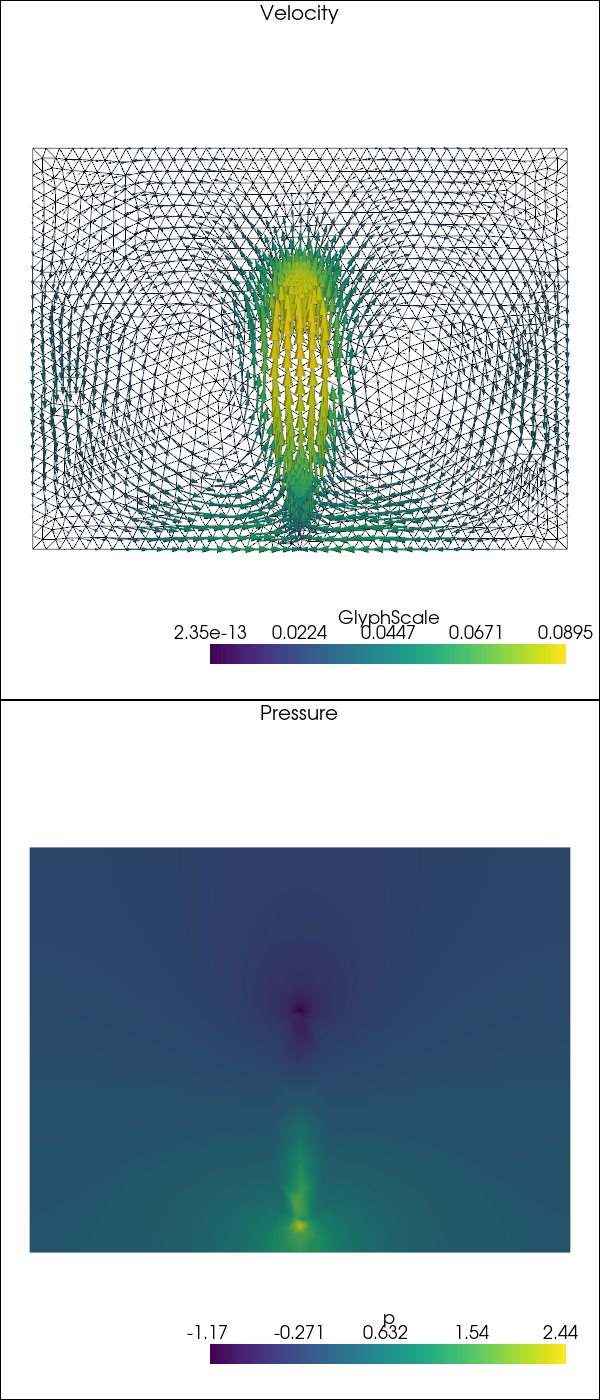

In [5]:
par = parameters()
describeModel(par)
runScenario(par)

## Scenario 2: a circular anomaly?

Model description.
A 2-D block that has two horizontal layers.
The bottom and top layers are  1.0 0.5  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.4 0.4  is inserted and its center is located at 1.0 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 10  respectively.
The gravity anomaly for the ellipse is  10.0
Boundary conditions are  free slip for all surfaces.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 299 nodes
Info    : 596 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 2.695175882721011
(B) Norm of pressure coefficient vector (blocked, iterative): 16.840311299737284


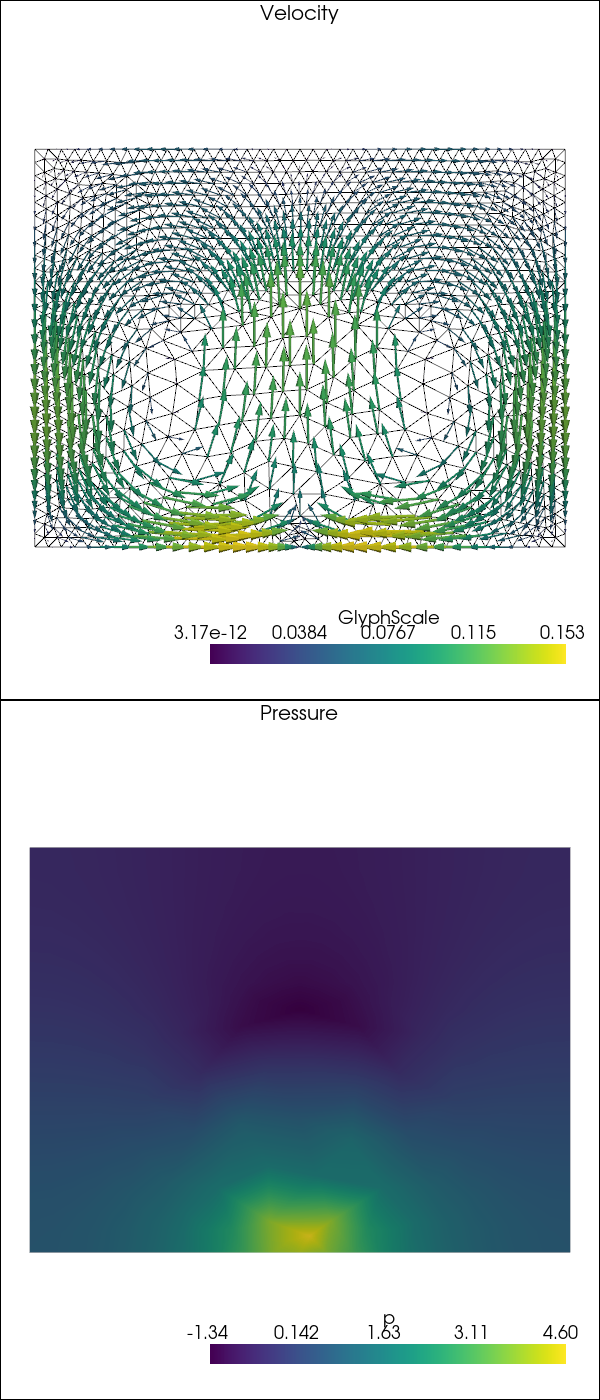

In [6]:
par = parameters()
par.ra, par.rb = 0.4, 0.4 # make a circular anomaly
describeModel(par)
runScenario(par)

## Scenario 3: make the top surface free?
Is there any problem with the model setup? Hint: incompressibily assumption?

Model description.
A 2-D block that has two horizontal layers.
The bottom and top layers are  1.0 0.5  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.4 0.1  is inserted and its center is located at 1.0 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 10  respectively.
The gravity anomaly for the ellipse is  10.0
Boundary conditions are  free slip for lateral sides and bottom, but the top is free.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 428 nodes
Info    : 854 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 6.452228492213527
(B) Norm of pressure coefficient vector (blocked, iterative): 11.11289638737506


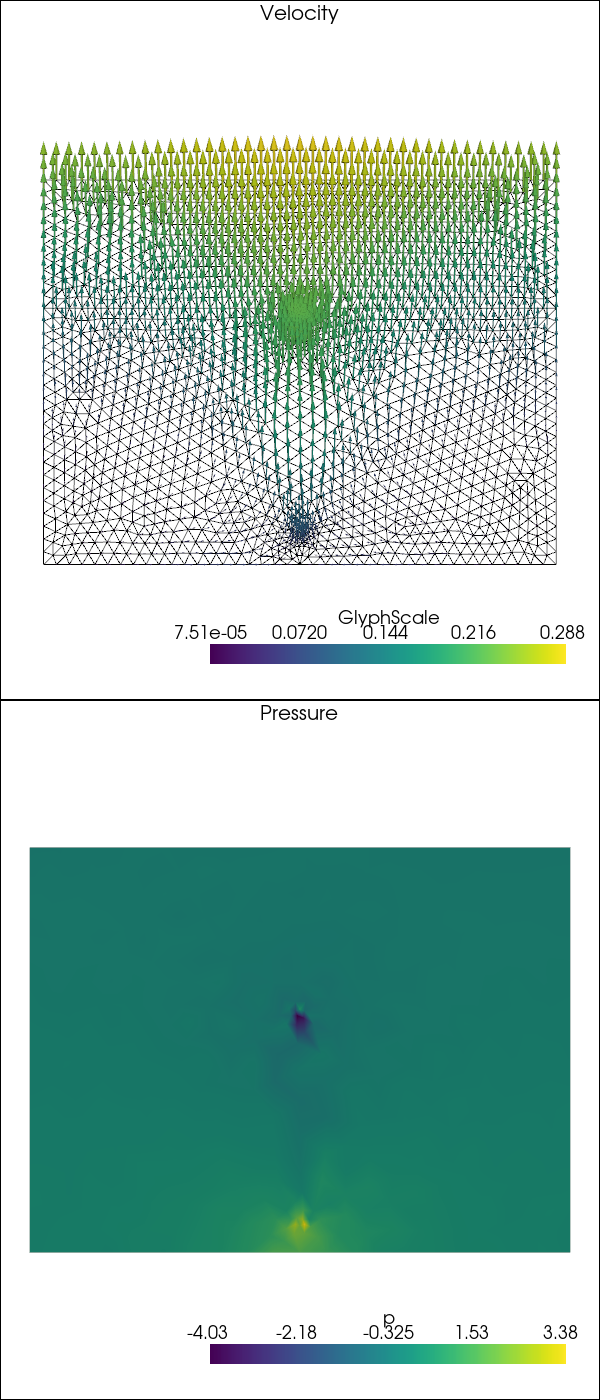

In [7]:
# Scenario 3: make the top surface free? 
par = parameters()
par.bcs_type = 2
describeModel(par)
runScenario(par)

## Scenario 4: simple shearing? 

Model description.
A 2-D block that has two horizontal layers.
The bottom and top layers are  1.0 0.5  in height, respectively.
An ellipitical shaped anomaly that has half major and minor axis lengths of 0.4 0.1  is inserted and its center is located at 1.0 0.5
The ellipse can be rotated counterclockwise with par.rot in radians. The default value is  0.5  pi.
The viscosities of the top, bottom, and elliptical anomaly are  1.0 1.0 10  respectively.
The gravity anomaly for the ellipse is  10.0
Boundary conditions are  no slip at bottom, fixed velocity for top, and only horizontal motion and no shear traction for lateral sides.
 
Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 428 nodes
Info    : 854 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 21.80584733911463
(B) Norm of pressure coefficient vector (blocked, iterative): 12.762069701605675


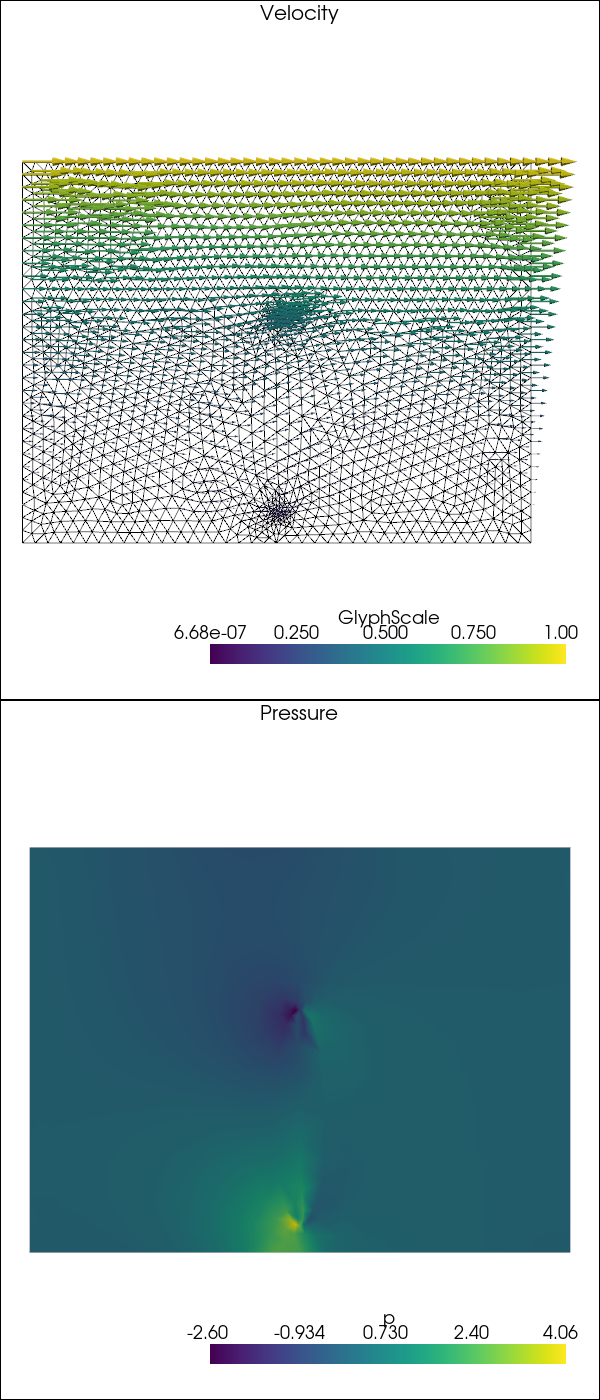

In [8]:
par = parameters()
par.bcs_type = 3
describeModel(par)
runScenario(par)

## Scenario 5: are boundaries affecting the results not as intended? 
Let's increase the model domain and see how the amplitudes of flows compared to scenario 1. 

Info    : Reading 'stokes.msh'...
Info    : 18 entities
Info    : 3255 nodes
Info    : 6508 elements
Info    : Done reading 'stokes.msh'
(B) Norm of velocity coefficient vector (blocked, iterative): 6.4322024777971
(B) Norm of pressure coefficient vector (blocked, iterative): 10.610150818441626


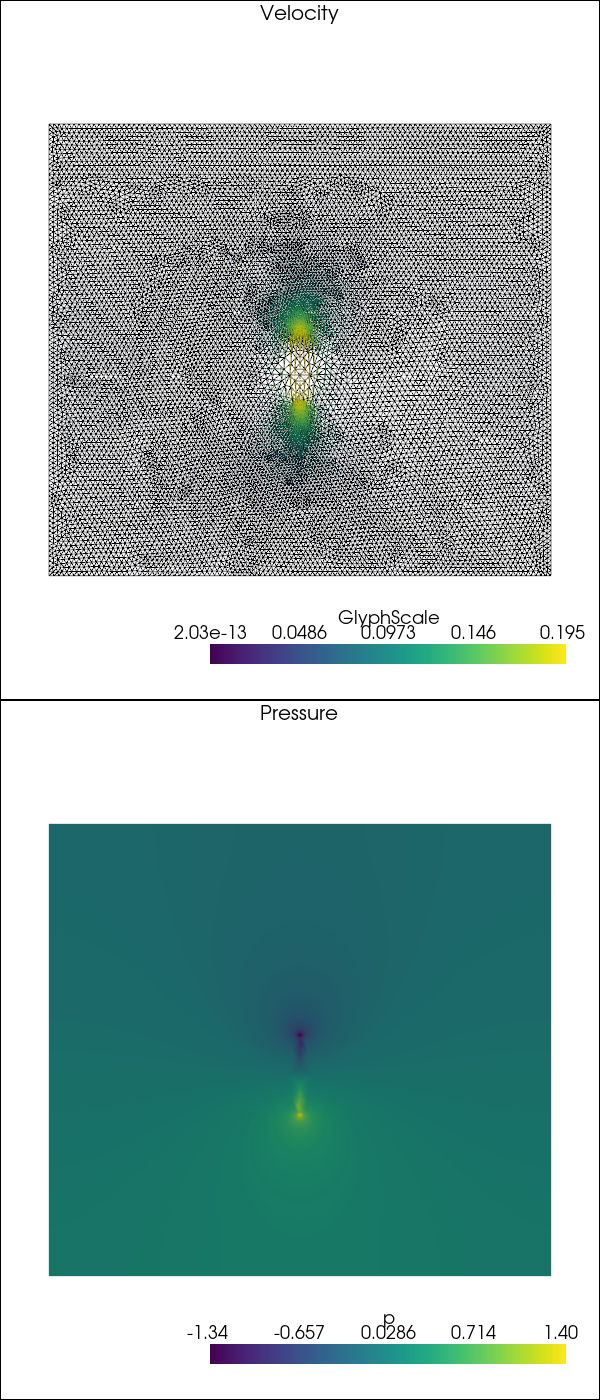

In [9]:
par = parameters()
par.w, par.h1, par.h2 = 5, 4, 0.5
par.xe, par.ye = par.w/2., par.h1/2.
runScenario(par)